# Build 2D Poisson Matrix as a Weighted Graph Laplacian 

## Import Libraries 

In [1]:
using LinearAlgebra 
using SparseArrays 

using BenchmarkTools
using Profile
using ProfileView

using Plots 

## Section 1:/ Introduction
The <b>goal</b> of this notebook is to extend previous implementations of the two-dimensional finite method for the Poisson eqiuation from a constant to a non-constant diffusion coefficient. The application of the electric field in a dielectricum between the plates of a capacitor is used as example. A reference solution is given in [Capacitor with a Dielectric](https://www.compadre.org/Physlets/electromagnetism/illustration26_3.cfm).    

We replace the construction of the matrix $A$ as the sum of two Kronecker products (i.e. $A = A_{xx} + A_{yy} = {\cal A} \otimes I + I \otimes {\cal A}$) by the construction of $A$ as a so-called [graph Laplacian](https://en.wikipedia.org/wiki/Laplacian_matrix). In this latter construction, the finite difference mesh on the rectangular domain is viewed as a graph in which edges connect nodes. The graph Laplacian matrix $A$ is formed as $A = B^T \, D \, B$ where the matrix $B$ is the rectangular node-edge incidence matrix and the matrix $D$ is a diagonal matrix of weights. 

To be more precise, let the two-dimensinal finite-difference mesh be constructed using $nx$ and $ny$ cells in the $x$- and $y$-direction, respectively. That the total number of nodes (including those on the boundary) on the graph is given by $\text{npoints} = (nx+1)*(ny+1)$. The edges on the graph can be divided between horizontal and vertical edges. The number of horizontal (or vertical) edges is given by $(ny+1)*nx$ (or $(nx+1)*ny$). The total number of edges is thus equal to $\text{nedges} = (ny+1)*nx + (nx+1)*ny$. The size of the rectangular matrix $B$ is nedges-by-npoints. Each row of $B$ corresponds to an edge of the graph. Edges of the graph are assumed to be oriented. If edge $k$ connects node $i$ and node $j$, then $B[k,i] = 1$ and $B[k,j] = -1$. The size of the diagonal matrix $D$ is nedges-by-nedges. Each diagonal entry of $D$ corresponds to a weight of an edge.   

Having constructed the matrices $B$ and $D$ avaible, the graph Laplacian matrix $A = B^T \, B$ or the weighted graph Laplacian matrix $A = B^T \, D \, B$ can be constructed. The size of $A$ is nnodes-by-nnodes as expected. 

This notebook is <b>structured</b> as follows: 
1. Section 2: build the node-edge incidence matrix $B$, build the graph Laplacian $ A = B^T \, B$ and apply to case of capacitor plates in vacuum; 
2. Section 3: build the diagonal matrix $D$ with weights on the edges, build the weighted graph Laplacian $A = B^T \, D \, B$ and apply to case of dielectrum between capacitor plates;

## Section 2:/ Construction of the Graph Laplacian  
Builds graph Laplacian $A = B^T \, B$ on a uniform mesh assuming x-lexicographical ordering of the nodes. The matrix $B$ here holds the node-edge connectivity. The nodes connected to the boundary might still require adjustment (to implement Neumann boundary conditions for instance). 

### Subsection 1.2:/ Build Node-Edge Incidence Matrix $B$ 

In [2]:
function node_edge_incidence_matrix_2D(nx,ny)
  nxp1 = nx+1; nyp1 = ny+1; 
  nedges  = nxp1*ny+nx*nyp1;
  npoints = nxp1*nyp1; 
  B = zeros(nedges,npoints)
  k = 1; # initialize edge counter to one  
  # edges going from left to right 
  for j=1:nyp1
    for i=1:nx
        I = (j-1)*nxp1+i; B[k,I] = 1; B[k,I+1] = -1; k+=1;
    end
  end
  # edges going to bottom to top 
  for j=1:ny
    for i=1:nxp1
        I = (j-1)*nxp1+i; B[k,I] = 1; B[k,I+nxp1] = -1; k+=1;
    end
  end
  return B
end

node_edge_incidence_matrix_2D (generic function with 1 method)

### Subsection 2.2:/ Build Graph Laplacian  $A = B^T \, B$ on Small Mesh

In [3]:
nx = 3; ny = 3; 
B = node_edge_incidence_matrix_2D(nx,ny)
A = Transpose(B)*B 

16×16 Matrix{Float64}:
  2.0  -1.0   0.0   0.0  -1.0   0.0  …   0.0   0.0   0.0   0.0   0.0   0.0
 -1.0   3.0  -1.0   0.0   0.0  -1.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0  -1.0   3.0  -1.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0  -1.0   2.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
 -1.0   0.0   0.0   0.0   3.0  -1.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0  -1.0   0.0   0.0  -1.0   4.0  …   0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0  -1.0   0.0   0.0  -1.0     -1.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0  -1.0   0.0   0.0      0.0  -1.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0  -1.0   0.0      0.0   0.0  -1.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0  -1.0     -1.0   0.0   0.0  -1.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0  …   4.0  -1.0   0.0   0.0  -1.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0     -1.0   3.0   0.0   0.0   0.0  -1.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   2.0  -1.0   0.0   0.0
  

### Section 3.2:/ Application to Capacitor Plates in Vacuum 

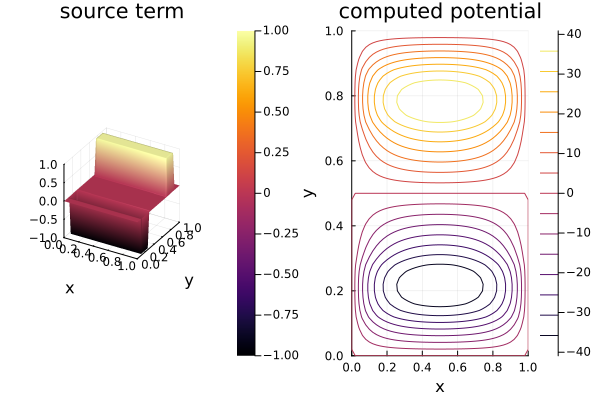

In [16]:
#..set number of intervals (N)
N = 50; 
#..compute derived numbers such as 
#..the points on the boundary (Nbnd) and the mesh width (h)
Np1 = N+1; Nm1 = N-1; Np2 = Np1*Np1; Nm2 = Nm1*Nm1; Nbnd = 4*N; h = 1/N; h2=h*h; 

#..construct the 2D mesh (X) starting from the 1D mesh (x)  
#..observe that we make in the 2D mesh the x coordinate increase from left to right and 
#..the y coordinate increase from top to bottom (as expected)
x = Vector(0:h:1); 
y = Vector(0:h:1); 
X = repeat(reshape(x, 1, :), length(y), 1);
Y = repeat(y, 1, length(x));

#..construct the mesh indicator matrix IG 
#..this indicator matrix will allow to distinguish interior and boundary nodes 
#..in this indicator matrix the boundary nodes are easy to identify 
#..for interior nodes IG(i,j) = 0 and for the boundary nodes IG(i,j) = 1
#..next construct the indicator vector IGvec by reshaping the indicator matrix IG  
IG = ones(Np1,Np1); 
IG[2:end-1,2:end-1] = zeros(Nm1,Nm1); 
IGvec = reshape(IG,Np2,1); 
#..construct array with linear indices allowing to define interior and boundary nodes 
#..interior: index array with all indices of the interior nodes 
#..boundary: index array with indices of all the boundary nodes 
L = LinearIndices(IGvec); 
interior_cartesian = findall(x->x==0,IGvec);  interior = L[interior_cartesian]; 
boundary_cartesian = findall(x->x>0,IGvec); boundary = L[boundary_cartesian]; 

#..construct auxiliary vectors used in the 1D code as well 
e = ones(Np1);            #..same as in 1D.. 
e_bnd = ones(Nbnd); #..used to handle the boundary nodes 

#..construct incidence matrix and graph Laplacian  
nx = N; ny = N; 
B = node_edge_incidence_matrix_2D(nx,ny)
A = Transpose(B)*B 
I_bnd = Diagonal(e_bnd); 

#..Construct the right-hand side vector 
#..Define the source function 
#..Observe the use of double brackets to make f work on a tuple of coordinates (x,y)
# sourceterm(x,y) = (x>0.3)*(x<0.7)*(y>0.7)*(y<0.9) - (x>0.3)*(x<0.7)*(y>.1)*(y<.3); 
sourceterm(x,y) = (y>0.7)*(y<0.9) - (y>.1)*(y<.3); 
#..Evaluate fsource on each node of the grid (Xh)
#..Observe the use of the dot syntax to evaluate fsource in all mesh nodes in X 
F = sourceterm.(X,Y); 
#..Reshape the F 2D array into an f vector 
f = reshape(F,Np2); 

#..Handle the Dirichlet boundary conditions in the matrix and the right-hand side vector 
A[boundary,boundary] = I_bnd; A[boundary,interior] = zeros(Nbnd, Nm2); 
f[boundary] = zeros(Nbnd); 

#..solve the linear system for the finite difference approximation 
u = A \ f; 

#..reshape the computed approximation 
U = reshape(u,Np1,Np1); 

#..plot the computed approximation as a contour plot 
p1 = surface(x, y, F, xlabel="x", ylabel="y", title="source term")
p2 = contour(x, y, U, xlabel="x", ylabel="y", title="computed potential")
plot(p1,p2)

## Section 3:/ Construction of the Weighted Graph Laplacian  
Builds graph Laplacian $A = B^T \, D \, B$ on a uniform mesh assuming x-lexicographical ordering of the nodes. The matrix $B$ and $D$ hold the node-edge connectivity and the weights on the edges, respectively.  

### Section 1.3:/ Build Diagonal Matrix with Weights on the Edges  

In [92]:
function weight_matrix_2D(nx,ny)
  nxp1 = nx+1; nyp1 = ny+1; 
  nedgesx = nxp1*ny; 
  nedgesy = nx*nyp1;
  nedges  = nxp1*ny+nx*nyp1;
  npoints = nxp1*nyp1; 
  Dx = ones(nedgesx); 
  Dy = ones(nedgesy); 
  lowx  = round(Int64,nedgesx/4)
  highx = round(Int64,3*nedgesx/4)
  # highx = round(Int64,nedgesx/2)
  lowy  = round(Int64,nedgesy/4)
  highy = round(Int64,3*nedgesy/4)    
  Dx[lowx:highx] .= 100;
  Dy[lowy:highy] .= 100;
  D = Diagonal([Dx ; Dy]) 
  return D 
end

weight_matrix_2D (generic function with 1 method)

In [93]:
nx = 3; ny = 3; 
D = weight_matrix_2D(nx,ny)

24×24 Diagonal{Float64, Vector{Float64}}:
 1.0   ⋅      ⋅      ⋅      ⋅      ⋅   …     ⋅      ⋅      ⋅    ⋅    ⋅    ⋅ 
  ⋅   1.0     ⋅      ⋅      ⋅      ⋅         ⋅      ⋅      ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅   100.0     ⋅      ⋅      ⋅         ⋅      ⋅      ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅      ⋅   100.0     ⋅      ⋅         ⋅      ⋅      ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅      ⋅      ⋅   100.0     ⋅         ⋅      ⋅      ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅      ⋅      ⋅      ⋅   100.0  …     ⋅      ⋅      ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅      ⋅      ⋅      ⋅      ⋅         ⋅      ⋅      ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅      ⋅      ⋅      ⋅      ⋅         ⋅      ⋅      ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅      ⋅      ⋅      ⋅      ⋅         ⋅      ⋅      ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅      ⋅      ⋅      ⋅      ⋅         ⋅      ⋅      ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅      ⋅      ⋅      ⋅      ⋅   …     ⋅      ⋅      ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅      ⋅      ⋅      ⋅      ⋅         ⋅      ⋅      ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅      ⋅      ⋅      ⋅     

### Section 2.3:/ Build Weighted Graph Laplacian   

In [94]:
nx = 3; ny = 3; 
B = node_edge_incidence_matrix_2D(nx,ny)
D = weight_matrix_2D(nx,ny)
A = Transpose(B)*D*B 

16×16 Matrix{Float64}:
  2.0  -1.0     0.0     0.0    -1.0  …     0.0     0.0   0.0   0.0   0.0
 -1.0   3.0    -1.0     0.0     0.0        0.0     0.0   0.0   0.0   0.0
  0.0  -1.0   201.0  -100.0     0.0        0.0     0.0   0.0   0.0   0.0
  0.0   0.0  -100.0   200.0     0.0        0.0     0.0   0.0   0.0   0.0
 -1.0   0.0     0.0     0.0   201.0        0.0     0.0   0.0   0.0   0.0
  0.0  -1.0     0.0     0.0  -100.0  …     0.0     0.0   0.0   0.0   0.0
  0.0   0.0  -100.0     0.0     0.0        0.0     0.0   0.0   0.0   0.0
  0.0   0.0     0.0  -100.0     0.0     -100.0     0.0   0.0   0.0   0.0
  0.0   0.0     0.0     0.0  -100.0        0.0  -100.0   0.0   0.0   0.0
  0.0   0.0     0.0     0.0     0.0        0.0     0.0  -1.0   0.0   0.0
  0.0   0.0     0.0     0.0     0.0  …  -100.0     0.0   0.0  -1.0   0.0
  0.0   0.0     0.0     0.0     0.0      201.0     0.0   0.0   0.0  -1.0
  0.0   0.0     0.0     0.0     0.0        0.0   101.0  -1.0   0.0   0.0
  0.0   0.0     0.0     0.0 

### Section 3.3:/ Application to Dielectrum Between Capacitor Plates

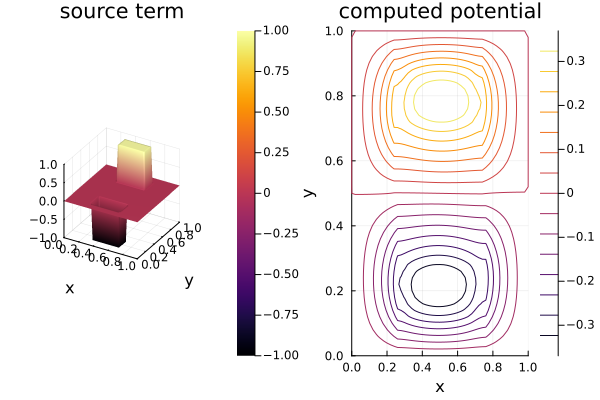

In [95]:
#..set number of intervals (N)
N = 50; 
#..compute derived numbers such as 
#..the points on the boundary (Nbnd) and the mesh width (h)
Np1 = N+1; Nm1 = N-1; Np2 = Np1*Np1; Nm2 = Nm1*Nm1; Nbnd = 4*N; h = 1/N; h2=h*h; 

#..construct the 2D mesh (X) starting from the 1D mesh (x)  
#..observe that we make in the 2D mesh the x coordinate increase from left to right and 
#..the y coordinate increase from top to bottom (as expected)
x = Vector(0:h:1); 
y = Vector(0:h:1); 
X = repeat(reshape(x, 1, :), length(y), 1);
Y = repeat(y, 1, length(x));

#..construct the mesh indicator matrix IG 
#..this indicator matrix will allow to distinguish interior and boundary nodes 
#..in this indicator matrix the boundary nodes are easy to identify 
#..for interior nodes IG(i,j) = 0 and for the boundary nodes IG(i,j) = 1
#..next construct the indicator vector IGvec by reshaping the indicator matrix IG  
IG = ones(Np1,Np1); 
IG[2:end-1,2:end-1] = zeros(Nm1,Nm1); 
IGvec = reshape(IG,Np2,1); 
#..construct array with linear indices allowing to define interior and boundary nodes 
#..interior: index array with all indices of the interior nodes 
#..boundary: index array with indices of all the boundary nodes 
L = LinearIndices(IGvec); 
interior_cartesian = findall(x->x==0,IGvec);  interior = L[interior_cartesian]; 
boundary_cartesian = findall(x->x>0,IGvec); boundary = L[boundary_cartesian]; 

#..construct auxiliary vectors used in the 1D code as well 
e = ones(Np1);            #..same as in 1D.. 
e_bnd = ones(Nbnd); #..used to handle the boundary nodes 

#..construct incidence matrix and graph Laplacian  
nx = N; ny = N; 
B = node_edge_incidence_matrix_2D(nx,ny)
D = weight_matrix_2D(nx,ny)
A = Transpose(B)*D*B 
I_bnd = Diagonal(e_bnd); 

#..Construct the right-hand side vector 
#..Define the source function 
#..Observe the use of double brackets to make f work on a tuple of coordinates (x,y)
sourceterm(x,y) = (x>0.3)*(x<0.7)*(y>0.7)*(y<0.9) - (x>0.3)*(x<0.7)*(y>.1)*(y<.3); 
# sourceterm(x,y) = (y>0.7)*(y<0.9) - (y>.1)*(y<.3); 
#..Evaluate fsource on each node of the grid (Xh)
#..Observe the use of the dot syntax to evaluate fsource in all mesh nodes in X 
F = sourceterm.(X,Y); 
#..Reshape the F 2D array into an f vector 
f = reshape(F,Np2); 

#..Handle the Dirichlet boundary conditions in the matrix and the right-hand side vector 
A[boundary,boundary] = I_bnd; A[boundary,interior] = zeros(Nbnd, Nm2); 
f[boundary] = zeros(Nbnd); 

#..solve the linear system for the finite difference approximation 
u = A \ f; 

#..reshape the computed approximation 
U = reshape(u,Np1,Np1); 

#..plot the computed approximation as a contour plot 
p1 = surface(x, y, F, xlabel="x", ylabel="y", title="source term")
p2 = contour(x, y, U, xlabel="x", ylabel="y", title="computed potential")
plot(p1,p2)

# To be placed in other notebook

using DifferentialEquations

In [170]:
G = zeros(6,5);
G[1,1] = -1; G[1,2] = 1; # edge 1 
G[2,2] = -1; G[2,3] = 1; # edge 2
G[3,3] = -1; G[3,4] = 1; # edge 3 
G[4,5] = -1; G[4,2] = 1; # edge 4 
G[5,3] = -1; G[5,5] = 1; # edge 5 
G[6,4] = -1; G[6,5] = 1; # edge 6
display(G)

6×5 Matrix{Float64}:
 -1.0   1.0   0.0   0.0   0.0
  0.0  -1.0   1.0   0.0   0.0
  0.0   0.0  -1.0   1.0   0.0
  0.0   1.0   0.0   0.0  -1.0
  0.0   0.0  -1.0   0.0   1.0
  0.0   0.0   0.0  -1.0   1.0

In [171]:
D = Diagonal(1000*ones(6))

6×6 Diagonal{Float64, Vector{Float64}}:
 1000.0      ⋅       ⋅       ⋅       ⋅       ⋅ 
     ⋅   1000.0      ⋅       ⋅       ⋅       ⋅ 
     ⋅       ⋅   1000.0      ⋅       ⋅       ⋅ 
     ⋅       ⋅       ⋅   1000.0      ⋅       ⋅ 
     ⋅       ⋅       ⋅       ⋅   1000.0      ⋅ 
     ⋅       ⋅       ⋅       ⋅       ⋅   1000.0

In [172]:
A = -Transpose(G)*D*G
f = zeros(5); f[1] = 1;

In [224]:
function myrhsode!(du,u,p,t,A)
    du[:] = A*u 
end 

myrhsode! (generic function with 2 methods)

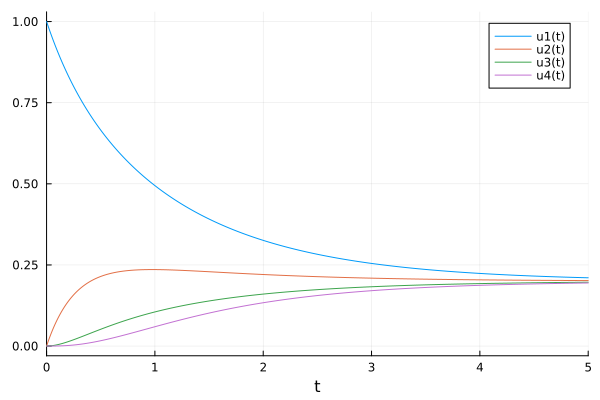

In [225]:
# problem set-up: set initial guess 
u0=zeros(5); u0[1] = 1; 
# problem set-up: set the time span 
tspan = (0.0,5.0)
# problem set-up: define the ODE problem 
prob = ODEProblem(myrhsode!,u0,tspan,A)

# perform time integration 
sol = solve(prob)

plot(sol,idxs=1)
plot!(sol,idxs=2)
plot!(sol,idxs=3)
plot!(sol,idxs=4)

f = zeros(5); f[3] = 1; 
display(f)

In [130]:
A = Transpose(G)*G
A[1,:] .= 0; A[1,1] = 1; 
A
v = ones(5)
w = A *v 
display(A)
display(w)

5×5 Matrix{Float64}:
  1.0   0.0   0.0   0.0   0.0
 -1.0   3.0  -1.0   0.0  -1.0
  0.0  -1.0   3.0  -1.0  -1.0
  0.0   0.0  -1.0   2.0  -1.0
  0.0  -1.0  -1.0  -1.0   3.0

5-element Vector{Float64}:
 1.0
 0.0
 0.0
 0.0
 0.0

In [126]:
display(f)
u = A \ (f)

5-element Vector{Float64}:
 0.0
 0.0
 1.0
 0.0
 0.0

5-element Vector{Float64}:
 0.0
 1.0000000000000002
 1.6250000000000002
 1.5000000000000002
 1.3750000000000002

## Second attempt: Linear Mesh 

In [191]:
# network with 6 nodes and 5 edges 
G = zeros(5,6);
G[1,1] = -1; G[1,2] = 1; # edge 1 
G[2,2] = -1; G[2,3] = 1; # edge 2
G[3,3] = -1; G[3,4] = 1; # edge 3 
G[4,4] = -1; G[4,5] = 1; # edge 4 
G[5,5] = -1; G[5,6] = 1; # edge 5 
display(G)

5×6 Matrix{Float64}:
 -1.0   1.0   0.0   0.0   0.0  0.0
  0.0  -1.0   1.0   0.0   0.0  0.0
  0.0   0.0  -1.0   1.0   0.0  0.0
  0.0   0.0   0.0  -1.0   1.0  0.0
  0.0   0.0   0.0   0.0  -1.0  1.0

In [192]:
A = -Transpose(G)*G
# A[1,:] .=0; A[1,1] = 1;
# A[end,:] .=0; A[end,end] = 1;
display(A)

6×6 Matrix{Float64}:
 -1.0   1.0   0.0   0.0   0.0   0.0
  1.0  -2.0   1.0   0.0   0.0   0.0
  0.0   1.0  -2.0   1.0   0.0   0.0
  0.0   0.0   1.0  -2.0   1.0   0.0
  0.0   0.0   0.0   1.0  -2.0   1.0
  0.0   0.0   0.0   0.0   1.0  -1.0

In [193]:
# set source term
f = zeros(6); f[3] = 1; 
display(f)

6-element Vector{Float64}:
 0.0
 0.0
 1.0
 0.0
 0.0
 0.0

In [196]:
# backward implicit Euler 
dt = 0.1; B = Diagonal(ones(6)) - dt*A

6×6 Matrix{Float64}:
  1.1  -0.1   0.0   0.0   0.0   0.0
 -0.1   1.2  -0.1   0.0   0.0   0.0
  0.0  -0.1   1.2  -0.1   0.0   0.0
  0.0   0.0  -0.1   1.2  -0.1   0.0
  0.0   0.0   0.0  -0.1   1.2  -0.1
  0.0   0.0   0.0   0.0  -0.1   1.1

In [197]:
# single step Euler backwards 
v = B\f

6-element Vector{Float64}:
 0.006451586238820282
 0.0709674486270231
 0.8451577972854569
 0.07092611879845923
 0.005955628296053829
 0.0005414207541867118

In [198]:
u = A \ f
display(u)

LoadError: SingularException(6)

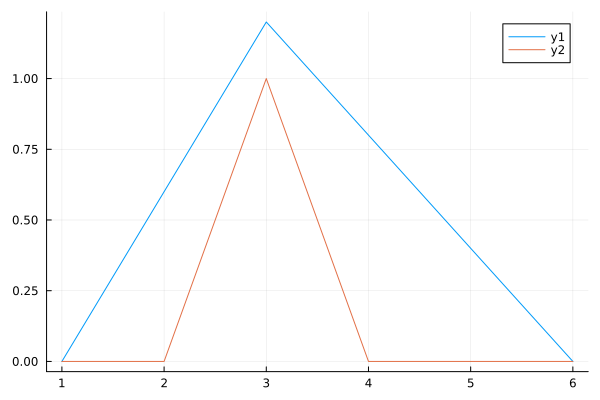

In [149]:
p1 = plot(u)
p1 = plot!(f)

In [205]:
function myrhsode2!(du,u,p,t)
# observe that specifying first component of u is required here
  G = zeros(5,6);
  G[1,1] = -1; G[1,2] = 1; # edge 1 
  G[2,2] = -1; G[2,3] = 1; # edge 2
  G[3,3] = -1; G[3,4] = 1; # edge 3 
  G[4,4] = -1; G[4,5] = 1; # edge 4 
  G[5,5] = -1; G[5,6] = 1; # edge 5 
  D = Diagonal(1000*ones(6))
  A = -Transpose(G)*G
  du[:] = A*u 
end 

myrhsode2! (generic function with 1 method)

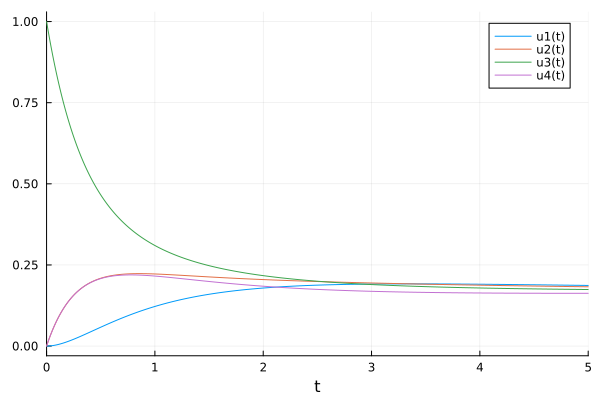

In [212]:
# problem set-up: set initial guess 
u0=zeros(6); u0[3] = 1; 
# problem set-up: set the time span 
tspan = (0.0,5.0)
# problem set-up: define the ODE problem 
prob = ODEProblem(myrhsode2!,u0,tspan)

# perform time integration 
sol = solve(prob)

plot(sol,idxs=1)
plot!(sol,idxs=2)
plot!(sol,idxs=3)
plot!(sol,idxs=4)